#Import Modules

In [ ]:
!pip install keras_spiking
!pip install tensorflow==2.15.0

In [ ]:
import joblib
import pickle
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Conv2D, MaxPool2D
from keras import backend as K
from keras.layers import BatchNormalization
from keras.initializers import glorot_uniform
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
from keras.regularizers import l2
from keras.initializers import HeNormal
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Concatenate
from keras.models import Model
from tensorflow.keras import layers
from keras import metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from IPython import display
import matplotlib.pyplot as plt
import keras_spiking
%matplotlib inline

#Read and Process Data

In [ ]:
df = pd.read_pickle("/content/drive/MyDrive/FingerClassification/Model/Thumb+Index/data(index+thumb).pkl")

In [ ]:
len(df)

183457

In [ ]:
df = df.sort_values(by='Timestamp', ascending=True)

In [ ]:
# Bước 1: Làm phẳng mỗi mảng 2 chiều và tạo mảng 2 chiều cho việc scale
X_flattened = np.array([blob.flatten() for blob in df['Resized_Blobs'].values])

# Khởi tạo MinMaxScaler
min_max_scaler = MinMaxScaler()

# Bước 2: Fit và transform dữ liệu
X_min_max_scaled = min_max_scaler.fit_transform(X_flattened)


# Bước 3: Thêm dữ liệu đã được chuẩn hóa vào DataFrame
df['New'] = list(X_min_max_scaled)

In [ ]:
# Khởi tạo MinMaxScaler
scaler = MinMaxScaler()

# Lựa chọn các cột bạn muốn chuẩn hóa
columns_to_scale = ['Area']

# Áp dụng Min-Max scaling cho các cột đã chọn
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [ ]:
# Special Cases
df['Finger_Categorys'] = df['Finger'].replace({'little': 'Others', 'ring': 'Others', 'index': 'Others', 'middle': 'Others', 'thumb': 'Thumb'})
df['Finger_Categorys'] = df['Finger'] + "_" + df['Handedness']

In [ ]:
#Split Data
split_factor = 0.8
ptcp_train = df.Participant.unique()[:math.floor(len(df.Participant.unique())*split_factor)]
ptcp_test = df.Participant.unique()[math.floor(len(df.Participant.unique())*split_factor):]
df_train = df[df.Participant.isin(ptcp_train)].copy(deep=True)
df_test = df[df.Participant.isin(ptcp_test)].copy(deep=True)

In [ ]:
le = LabelEncoder()

X_train = np.stack(df_train[['New', 'Area']].values)
X_test = np.stack(df_test[['New', 'Area']].values)

X_train_features = np.array([sample[0] for sample in X_train])
X_train_area = np.array([sample[1] for sample in X_train])

X_test_features = np.array([sample[0] for sample in X_test])
X_test_area = np.array([sample[1] for sample in X_test])

y_train = df_train['Finger'].values
y_test = df_test['Finger'].values
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
# Chuyển đổi nhãn sang one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

In [ ]:
n_steps = 5

In [ ]:
# In ra mapping của labels sau khi đã được fit
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)

{'index': 0, 'thumb': 1}


In [ ]:
X_train_area = X_train_area.reshape(-1, 1)
X_test_area = X_test_area.reshape(-1, 1)

In [ ]:
X_train_features = np.tile(X_train_features[:, None, :], (1, n_steps, 1))
X_train_area = np.tile(X_train_area[:, None], (1, n_steps, 1))

X_test_features = np.tile(X_test_features[:, None, :], (1, n_steps, 1))
X_test_area = np.tile(X_test_area[:, None], (1, n_steps, 1))

#Build SNN Model

In [ ]:
# Đầu vào 1 có kích thước (64,)
n_steps = 5
input_64 = tf.keras.Input(shape=(n_steps, 64))

# Đầu vào 2 có kích thước (1,)
input_1 = tf.keras.Input(shape=(n_steps, 1))

# Feature 1
x1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128))(input_64)
x1 = keras_spiking.SpikingActivation("relu", dt = 0.35, spiking_aware_training=True)(x1)

# Feature 2
x2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128))(input_1)
x2 = keras_spiking.SpikingActivation("relu", dt = 0.35, spiking_aware_training=True)(x2)

#Merge input
merged = tf.keras.layers.Concatenate(axis=-1)([x1, x2])

# Các layer tiếp
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64))(merged)
x = keras_spiking.SpikingActivation("relu", dt = 0.35, spiking_aware_training=True)(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32))(x)
x = keras_spiking.SpikingActivation("relu", dt = 0.35, spiking_aware_training=True)(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16))(x)
x = keras_spiking.SpikingActivation("relu", dt = 0.35, spiking_aware_training=True)(x)

# Tổng hợp thông tin qua thời gian
x = tf.keras.layers.GlobalAveragePooling1D()(x)

# Output layer
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Tạo mô hình
model = tf.keras.Model(inputs=[input_64, input_1], outputs=output)

# Check model (params)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5, 64)]              0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 5, 128)               8320      ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (None, 5, 128)               256       ['input_2[0][0]']         

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#Training

In [ ]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/FingerClassification/Model/SNN(dt0.3num5)/5fingers/model_snn_5_fingers.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
history = model.fit(
    [X_train_features, X_train_area], y_train_one_hot,
    validation_data=([X_test_features, X_test_area], y_test_one_hot),
    epochs=50,
    batch_size = 16,
    callbacks=[checkpoint]
)


Epoch 1/50
17353/17353 [==============================] - 183s 10ms/step - loss: 1.5479 - categorical_accuracy: 0.2859 - val_loss: 1.4972 - val_categorical_accuracy: 0.3154
Epoch 2/50
    9/17353 [..............................] - ETA: 1:54 - loss: 1.5065 - categorical_accuracy: 0.3472

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17353/17353 [==============================] - 186s 11ms/step - loss: 1.4743 - categorical_accuracy: 0.3340 - val_loss: 1.4411 - val_categorical_accuracy: 0.3526
Epoch 3/50
17353/17353 [==============================] - 180s 10ms/step - loss: 1.4354 - categorical_accuracy: 0.3542 - val_loss: 1.4593 - val_categorical_accuracy: 0.3360
Epoch 4/50
17353/17353 [==============================] - 187s 11ms/step - loss: 1.4051 - categorical_accuracy: 0.3719 - val_loss: 1.4213 - val_categorical_accuracy: 0.3630
Epoch 5/50
17353/17353 [==============================] - 172s 10ms/step - loss: 1.3796 - categorical_accuracy: 0.3862 - val_loss: 1.4172 - val_categorical_accuracy: 0.3674
Epoch 6/50
17353/17353 [==============================] - 172s 10ms/step - loss: 1.3570 - categorical_accuracy: 0.4002 - val_loss: 1.4421 - val_categorical_accuracy: 0.3624
Epoch 7/50
17353/17353 [==============================] - 178s 10ms/step - loss: 1.3369 - categorical_accuracy: 0.4116 - val_loss: 1.4134 - val_ca

KeyboardInterrupt: 

#Evaluating

In [ ]:
from keras_spiking import SpikingActivation
from keras.models import load_model

# Load model with custom objects
snn_model = load_model('/content/drive/MyDrive/FingerClassification/Model/SNN(dt0.3num5)/Thumb-Index/model_snn_index_thumb.h5',
                       custom_objects={'SpikingActivation': SpikingActivation})


In [ ]:
from keras.metrics import CategoricalAccuracy
from keras.losses import CategoricalCrossentropy

snn_model.compile(loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])

loss, accuracy = snn_model.evaluate([X_test_features, X_test_area], y_test_one_hot, verbose=1)

print(f"Best model test loss: {loss}")
print(f"Best model test accuracy: {accuracy}")

1157/1157 [==============================] - 8s 6ms/step - loss: 0.4065 - categorical_accuracy: 0.8281
Best model test loss: 0.4064886271953583
Best model test accuracy: 0.8280566334724426


#Visualize Neuron Spikes

620/620 [==============================] - 5s 6ms/step
Accuracy: 0.7455994351137338
Test accuracy: 74.56%
Spike rate per neuron (Hz): min=0.00 mean=0.96 max=46.60


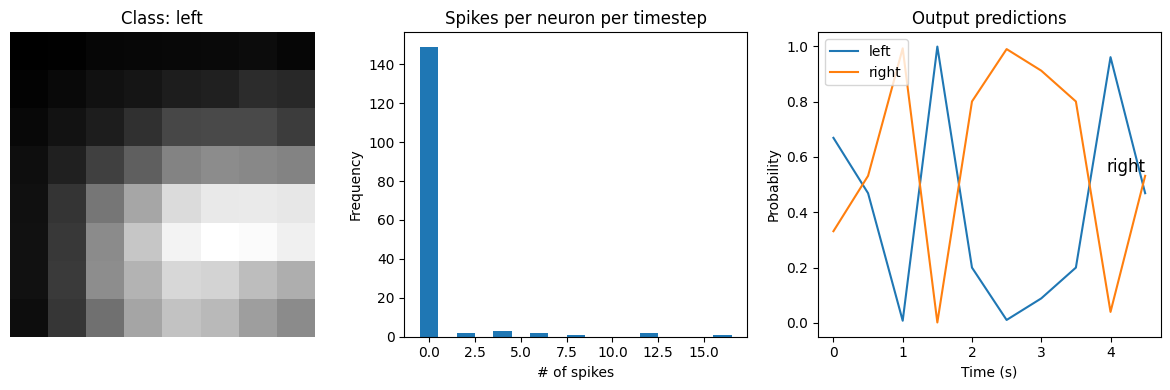

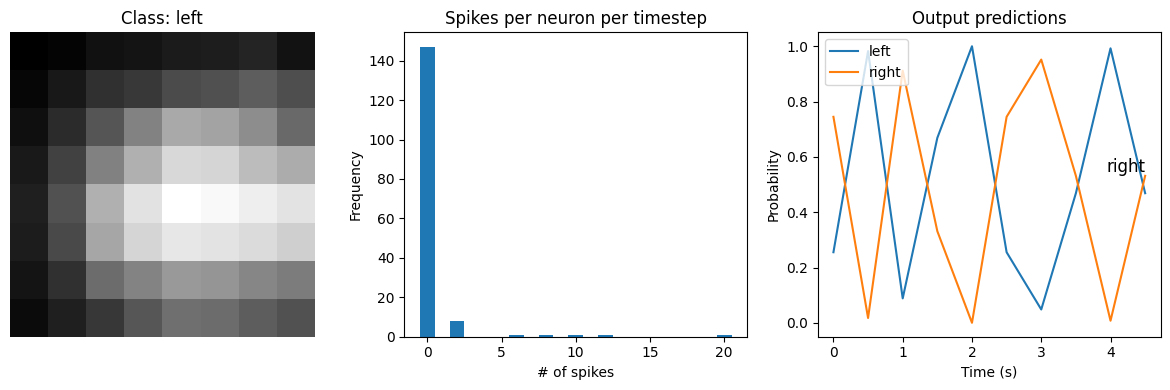

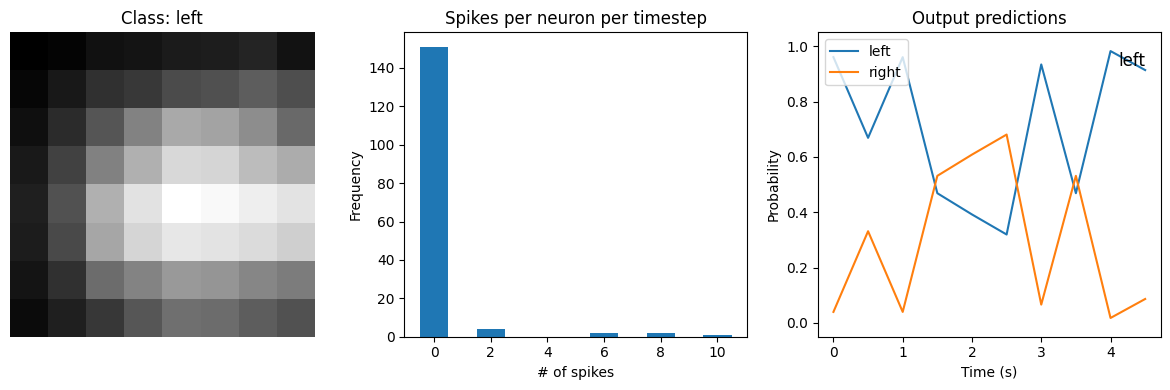

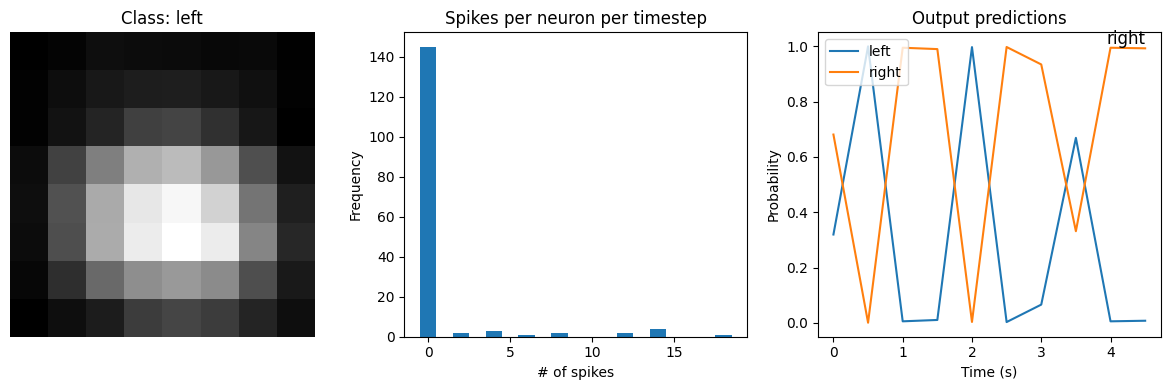

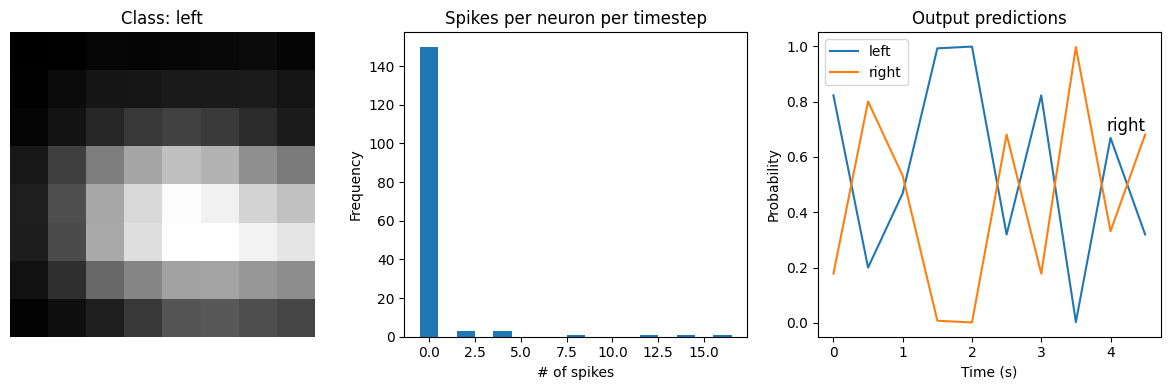

In [ ]:
pretrained_weights = snn_model.get_weights()

class_names = ['left', 'right']
def build_spiking_model(input_shape_64, input_shape_1, dt = 0.5):
    input_64 = tf.keras.Input(shape=input_shape_64)
    input_1 = tf.keras.Input(shape=input_shape_1)

    x1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128))(input_64)
    x1 = keras_spiking.SpikingActivation("relu", dt=dt, spiking_aware_training=True)(x1)

    x2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128))(input_1)
    x2 = keras_spiking.SpikingActivation("relu", dt=dt, spiking_aware_training=True)(x2)

    merged = tf.keras.layers.Concatenate(axis=-1)([x1, x2])
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64))(merged)
    x = keras_spiking.SpikingActivation("relu", dt=dt, spiking_aware_training=True,  return_sequences=True)(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32))(x)
    x = keras_spiking.SpikingActivation("relu", dt=dt, spiking_aware_training=True,  return_sequences=True)(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16))(x)
    spike_layer = keras_spiking.SpikingActivation("relu", dt=dt, spiking_aware_training=True, return_sequences=True)(x)
    output = tf.keras.layers.Dense(2)(spike_layer)

    model = tf.keras.Model(inputs=[input_64, input_1], outputs=[output, spike_layer])
    return model

prediction_model = build_spiking_model((None, 64), (None, 1))

prediction_model.set_weights(pretrained_weights)

# Chạy mô hình để lấy kết quả
output, spikes = prediction_model.predict([X_test_features, X_test_area])

# Tính toán độ chính xác
predictions = np.argmax(output[:, -1], axis=-1)
actual_classes = np.argmax(y_test_one_hot, axis=1)
accuracy = accuracy_score(actual_classes, predictions)
print("Accuracy:", accuracy)
accuracy = np.mean(predictions == actual_classes)
print(f"Test accuracy: {accuracy * 100:.2f}%")

time = X_test_features.shape[1] * prediction_model.layers[-4].dt
n_spikes = spikes * prediction_model.layers[-4].dt
spike_rates = np.sum(n_spikes, axis = 1)/ time
print(f"Spike rate per neuron (Hz): min={spike_rates.min():.2f} mean={spike_rates.mean():.2f} max={spike_rates.max():.2f}")

# Vẽ biểu đồ
for i in range(5):  # Vẽ cho 6 mẫu dữ liệu đầu tiên
    plt.figure(figsize=(12, 4))

    # Biểu đồ input
    plt.subplot(1, 3, 1)
    plt.imshow(X_test_features[i, 0].reshape(8, 8), cmap='gray')
    plt.title(f"Class: {class_names[actual_classes[i]]}")
    plt.axis('off')

    # Biểu đồ số spikes
    plt.subplot(1, 3, 2)
    plt.title("Spikes per neuron per timestep")
    bin_edges = np.arange(int(np.max(spikes[i])) + 2) - 0.5
    plt.hist(np.ravel(spikes[i]), bins=bin_edges)
    plt.xlabel("# of spikes")
    plt.ylabel("Frequency")

    # Biểu đồ dự đoán và nhãn dự đoán
    plt.subplot(1, 3, 3)
    plt.title("Output predictions")
    softmax_output = tf.nn.softmax(output[i], axis=1).numpy()
    time_points = np.arange(X_test_features.shape[1]) * prediction_model.layers[-4].dt
    plt.plot(time_points, softmax_output)
    plt.xlabel("Time (s)")
    plt.ylabel("Probability")
    plt.legend(class_names, loc="upper left")
    plt.ylim([-0.05, 1.05])

    # Lấy nhãn dự đoán cuối cùng từ softmax output
    final_prediction_index = np.argmax(softmax_output[-1])
    final_prediction_label = class_names[final_prediction_index]

    # Thêm nhãn dự đoán vào biểu đồ
    plt.text(time_points[-1], softmax_output[-1, final_prediction_index],
             f'{final_prediction_label}', fontsize=12, ha='right', va='bottom')

    plt.tight_layout()
    plt.show()

# for i in range(14000, 14100):
#     print(f"Sample {i} - Actual class: {class_names[actual_classes[i]]}")


#Estimate energy consumption

In [ ]:
# In ra các thiết bị đã đăng ký và thông số của chúng
print(keras_spiking.ModelEnergy.devices)

In [ ]:
n_steps = 5
example_data = [np.ones((32, n_steps, 64)), np.ones((32, n_steps, 1))]

# Ước tính mức tiêu thụ năng lượng
energy = keras_spiking.ModelEnergy(model, example_data=example_data)

# Hiển thị mức tiêu thụ năng lượng
energy.summary(
    columns=(
        "name",
        "rate",
        "energy cpu",
        "energy gpu",
        "energy loihi",
        "energy spinnaker",
        "energy spinnaker2",
        "energy arm"
    ),
    dt = 0.3,
    timesteps_per_inference = 5,
    print_warnings=False,
)

/usr/local/lib/python3.10/dist-packages/keras_spiking/model_energy.py:773: UserWarning: Cannot compute stats for layer of type 'Concatenate'.Use `ModelEnergy.register_layer` to register this layer.
  warnings.warn(


1/1 [==============================] - 2s 2s/step
Layer (type)    |Rate [Hz]|J/inf (cpu)|J/inf (gpu)|J/inf (loih|J/inf (spin|J/inf (spin|J/inf (arm)
----------------|---------|-----------|-----------|-----------|-----------|-----------|-----------
input_1 (InputLa|        1|          0|          0|          0|          0|          0|          0
input_2 (InputLa|        1|          0|          0|          0|          0|          0|          0
time_distributed|        1|      7e-05|    2.5e-06|    3.3e-07|    0.00016|    5.5e-06|    7.4e-06
time_distributed|        1|    1.1e-06|    3.8e-08|    5.2e-09|    2.6e-06|    8.6e-08|    1.2e-07
spiking_activati|     0.61|    1.1e-06|    3.8e-08|    5.2e-08|    1.7e-05|    1.4e-06|    1.2e-07
spiking_activati|     0.12|    1.1e-06|    3.8e-08|    5.2e-08|    1.7e-05|    1.4e-06|    1.2e-07
concatenate (Con|     0.18|          0|          0|          0|          0|          0|          0
time_distributed|     0.18|    0.00014|    4.9e-06|    1.2e